In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
import random
import torch.nn.utils
import textwrap
import re
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
from torchsummary import summary
import torch.nn.functional as F
import tiktoken
from transformers import AutoTokenizer
from datasets import load_dataset
import math
import datasets
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity

In [2]:
torch.cuda.empty_cache()

In [3]:
import os

tokenized_dataset_path = os.getcwd() + '/tokenized_train_dataset'

print(os.path.isdir(tokenized_dataset_path))

def tokenization(example):
    from transformers import AutoTokenizer
    # tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
    tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
    # tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token = tokenizer.eos_token
    return tokenizer(example['text'], truncation=True)

def chunk_examples(examples):
    window = 250
    chunks = []
    for sentence in examples["text"]:
        chunks += [sentence[i:i + window] for i in range(0, len(sentence), window)]
    return {"text": chunks}

def generate_tokenized_dataset(train: bool=True) -> DataLoader:
    # tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
    tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
    tokenizer.pad_token = tokenizer.eos_token
    if train:
        dataset_type = "train"
        tokenized_dataset_folder = 'tokenized_train_dataset'
        tokenized_dataset_path = os.getcwd() + '/' + tokenized_dataset_folder
    else:
        dataset_type = "test"
        tokenized_dataset_folder = 'tokenized_validation_dataset'
        tokenized_dataset_path = os.getcwd() + '/tokenized_validation_dataset'
    
    if os.path.isdir(tokenized_dataset_path):
        tokenized_entries = datasets.load_from_disk(tokenized_dataset_folder)
       
    else:
        dataset = load_dataset("roneneldan/TinyStories")
        dataset = dataset[dataset_type]
        updated_dataset = dataset#.map(chunk_examples, batched=True, remove_columns=dataset.column_names, num_proc=5)
        tokenized_entries = updated_dataset.map(tokenization, batched=True, num_proc=8)
        tokenized_entries.save_to_disk(tokenized_dataset_folder)
       
        
    
    tokenized_entries = tokenized_entries.remove_columns(["text"])
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
    data_loader = DataLoader(tokenized_entries, batch_size=4, shuffle=True, collate_fn=data_collator)
    return data_loader

False


In [4]:
from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
# tokenizer.pad_token = tokenizer.eos_token

train_loader = generate_tokenized_dataset(True)

tokenizer_config.json:   0%|          | 0.00/966 [00:00<?, ?B/s]

c:\Users\vjsam\anaconda3\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vjsam\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

c:\Users\vjsam\anaconda3\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Map (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

Saving the dataset (0/9 shards):   0%|          | 0/2119719 [00:00<?, ? examples/s]

In [27]:
print(tokenizer.pad_token)

None


In [5]:
print(tokenizer.vocab_size)

32000


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# file_paths = ['gutenberg_shakespeare.txt', 'gutenberg_war_and_peace.txt', 'gutenberg_don_quixote.txt', 'gutenberg_brothers_karamazov.txt']
# # file_paths = ['gutenberg_war_and_peace.txt']
# # Initialize an empty string to hold the combined content
# combined_string = ''

# # # Loop through each file path, open the file, read its content, and append it to the combined_string
# # for file_path in file_paths:
# #     file = open(file_path, 'r', encoding='utf-8-sig')
# #     combined_string += file.read().strip()
# #     file.close()  # Close the file after reading its content

# for file_path in file_paths:
#     with open(file_path, 'r', encoding='utf-8-sig') as file:
#         # Read file content, split by lines, strip each line and then join them back
#         content = file.read().splitlines()[30:-18500]
#         stripped_content = " ".join([line.strip() for line in content if line.strip()])  # Strip leading/trailing whitespace and remove empty lines
#         combined_string += stripped_content


# # combined_string = re.sub(r'\n\s*\n', '\n', combined_string)
# #combined_string = re.sub(r"[\n\t]*", "", combined_string)

# unique_chars = list(set(combined_string))
# # print(unique_chars)
# m = len(unique_chars)
# print(m)

# dataset = load_dataset("roneneldan/TinyStories")

In [33]:
# def chunk_examples(examples):
#     window = 500
#     chunks = []
#     for sentence in examples["text"]:
#         chunks += [sentence[i:i + window] for i in range(0, len(sentence), window)]
#     return {"text": chunks}

In [34]:
# train_dataset = dataset['train']
# updated_train_dataset = train_dataset.map(chunk_examples, batched=True,remove_columns=train_dataset.column_names, num_proc=5)

In [35]:
# encoding = tiktoken.get_encoding("r50k_base")
# tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

In [36]:
# tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
# tokenizer.pad_token = tokenizer.eos_token
# def tokenization(example):
#     from transformers import AutoTokenizer
#     tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
#     tokenizer.pad_token = tokenizer.eos_token
#     return tokenizer(example['text'], truncation=True)

In [37]:
# # train_dataset = dataset['train']
# # tokenized_entries = train_dataset.map(tokenization, batched=True)
# # tokenized_entries = encoding.batch_encode_plus(train_dataset['text'], 
# #                                                return_tensors="pt")
# # tokenized_entries = encoding(train_dataset['text'], return_tensors="pt")
# tokenized_entries = updated_train_dataset.map(tokenization, batched=True, num_proc=7)
# tokenized_entries.save_to_disk("tokenized_train_dataset")

In [38]:
# tokenized_entries = datasets.load_from_disk('tokenized_train_dataset')
# tokenized_entries = tokenized_entries.remove_columns(["text"])
# # print(tokenized_entries)

In [39]:
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
# train_loader = DataLoader(tokenized_entries, batch_size=int(32/2), shuffle=True, collate_fn=data_collator)

In [7]:
# input_feature_dim = m
# input_feature_dim = 50257
input_feature_dim = tokenizer.vocab_size
hidden_size = 256
# hidden_size = 2048

In [8]:
class TransformerModel(nn.Module):
    def __init__(self, input_feature_dim, d_model, num_heads, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(input_feature_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=0.1,dim_feedforward=2048),
            num_layers=num_layers,
            norm=nn.LayerNorm(d_model),
        )
        self.fc = nn.Linear(d_model, input_feature_dim)
        self.pos_encoder = PositionalEncoding(d_model)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        mask = self.generate_square_subsequent_mask(len(x)).to(device)
        x = x.permute(1,0,2)
        x = self.transformer(x, mask)
        x = x.permute(1,0,2)
        x = self.fc(x)
        return x
    

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        
        x = x + (self.pe[:x.size(0)])
        return x

In [15]:
num_heads = 6
num_layers = 6
transformer_model = TransformerModel(input_feature_dim, hidden_size-(hidden_size%num_heads), num_heads=num_heads, num_layers=num_layers).to(device)
# transformer_model = TransformerModel(input_feature_dim, int(input_feature_dim/2) - (int(input_feature_dim/2) % 4)).to(device)
pad_token = tokenizer.encode(tokenizer.pad_token)[0]
criterion = nn.CrossEntropyLoss(ignore_index=pad_token)
optimizer = optim.AdamW(transformer_model.parameters(), lr = 0.0001, betas=(0.9, 0.95))
# scheduler = MultiStepLR(optimizer, milestones=[2500, 7000], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.98)
# train_temperature = 1.0


In [16]:
def softmax_with_temperature(logits, temperature):
    return F.softmax(logits / temperature, dim=-1)

In [17]:
# print(summary(transformer_model, (1,m)))
pytorch_total_params = sum(p.numel() for p in transformer_model.parameters())
print(pytorch_total_params)


23903648


In [45]:
# combined_string = dataset['train'][:]['text']

# batch_size = 250
# batches = [combined_string[i:i+batch_size][0] for i in range(0, len(combined_string), batch_size)]
# if len(batches[-1]) != batch_size:
#     batches.pop()

# char_1 = 0
# batches = batches
# for i in batches:
#     char_1 += len(i)
# print(len(batches))
# print(len(combined_string))
# # print(batches[-1])
# print(dataset['train'][-1])
# print(combined_string[-1])
# batches = dataset['train']
# chars = 0
# for i,batch in enumerate(batches):
#     chars += len(batch['text'])
# # print(i)
# print(char_1)
# print(chars)
# num_sequences = 30000

In [18]:
num_epochs = 1
training_loss_values = []
training_error_values = []
validation_loss_values = []
validation_error_values = []
x_vals = []
x_val = 1
validation_x_vals = []
num_validation_seq = 5


for epoch in range(num_epochs):

    # loss_accumulator = 0
    # error_accumulator = 0
    
    for i,input in enumerate(train_loader):
        # with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
        #              record_shapes=True, 
        #              profile_memory=True, 
        #              use_cuda=torch.cuda.is_available()) as prof:
    # for i, input in enumerate(batches):
            # input = input['text']
            sequence = torch.tensor(input['input_ids']).to(device)
            # attn_mask = torch.tensor(input['attention_mask'])[:, 1:].to(device)
            # print(attn_mask.shape)
            # print(sequence.shape)
            transformer_model.train()
            # tokens = encoding.encode(input)
            # sequence = torch.tensor(tokens).long().to(device)
            labels = sequence[:,1:].contiguous().view(-1)
            output = transformer_model(sequence[:,:-1])
            # print(output.shape)
            # pad_tensor = torch.zeros_like(output)
            # pad_tensor[:, :, pad_token] = 1
            # attn_mask = attn_mask.unsqueeze(2).repeat(1,1,50257)
            # # print(attn_mask.unsqueeze(2).repeat(1,1,50257).shape)
            # output = torch.where(attn_mask==1, output, pad_tensor)
            
            output = output.view(-1, output.size(-1))
            
            loss = criterion(output,labels)
            # softmaxed_logits = softmax_with_temperature(output, train_temperature)
            # loss = nn.NLLLoss()(torch.log(softmaxed_logits), labels)
            optimizer.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(rnn.parameters(), 15.0)
            # loss_accumulator += loss.item()
            optimizer.step()
            # training_loss_values.append(loss.item())
            
            predicted_labels = torch.argmax(output,dim=1)
            training_error = 1.0 - (labels == predicted_labels).sum()/(len(labels))
            # training_error_values.append(training_error.item())
            # error_accumulator += training_error.item()

            # x_vals.append(x_val)

            # if x_val % 50 == 0:  # If 50 iterations have passed
            #     avg_loss = loss_accumulator / 50.0
            #     avg_error = error_accumulator / 50.0
            #     training_loss_values.append(avg_loss)
            #     training_error_values.append(avg_error)
            #     x_vals.append(x_val)
            #     # Reset the accumulators
            #     loss_accumulator = 0
            #     error_accumulator = 0

            training_loss_values.append(loss.item())
            training_error_values.append(training_error.item())

            if (x_val % 1000) == 0:
                transformer_model.eval()
                print('Iteration: {}/{}'.format(x_val, len(train_loader)))
                scheduler.step()

                # test_loss_accumulator = 0
                # test_error_accumulator = 0
                
                # # Validation
                # for j in range(num_validation_seq):
                #     future_sequence = torch.tensor(tokenized_train_dataset[i+j+1]['input_ids']).to(device)
                #     # future_tokens = encoding.encode(future_input)
                #     # future_sequence = torch.tensor(future_tokens).long().to(device)
                #     future_output = transformer_model(future_sequence[:-1])
                #     future_labels = future_sequence[1:]
                #     future_loss = criterion(future_output, future_labels)
                #     # future_softmaxed_logits = softmax_with_temperature(future_output, train_temperature)
                #     # future_loss = nn.NLLLoss()(torch.log(future_softmaxed_logits), future_labels)
                #     # validation_loss_values.append(future_loss.item())
                #     test_loss_accumulator += future_loss.item()
                #     future_predicted_labels = torch.argmax(future_output, dim=1)
                #     validation_error = (1.0 - (future_labels == future_predicted_labels).sum() / (len(future_sequence) - 1)).item()
                #     # validation_error_values.append(validation_error.item())
                #     test_error_accumulator += validation_error
                # validation_loss_values.append((test_loss_accumulator/num_validation_seq))
                # validation_error_values.append((test_error_accumulator/num_validation_seq))
                # validation_x_vals.append(x_val)
            
            if x_val==100000:
                break
                
            x_val +=1

            del loss, output, labels
        # print(prof.key_averages().table(sort_by="cuda_time_total"))
            # scheduler.step()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
C:\Users\vjsam\AppData\Local\Temp\ipykernel_51800\97658712.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(input['input_ids']).to(device)


Iteration: 1000/529930
Iteration: 2000/529930
Iteration: 3000/529930
Iteration: 4000/529930
Iteration: 5000/529930
Iteration: 6000/529930
Iteration: 7000/529930
Iteration: 8000/529930
Iteration: 9000/529930
Iteration: 10000/529930
Iteration: 11000/529930
Iteration: 12000/529930
Iteration: 13000/529930
Iteration: 14000/529930
Iteration: 15000/529930
Iteration: 16000/529930
Iteration: 17000/529930
Iteration: 18000/529930
Iteration: 19000/529930
Iteration: 20000/529930
Iteration: 21000/529930
Iteration: 22000/529930
Iteration: 23000/529930
Iteration: 24000/529930
Iteration: 25000/529930
Iteration: 26000/529930
Iteration: 27000/529930
Iteration: 28000/529930
Iteration: 29000/529930
Iteration: 30000/529930
Iteration: 31000/529930
Iteration: 32000/529930
Iteration: 33000/529930
Iteration: 34000/529930
Iteration: 35000/529930
Iteration: 36000/529930
Iteration: 37000/529930
Iteration: 38000/529930
Iteration: 39000/529930
Iteration: 40000/529930
Iteration: 41000/529930
Iteration: 42000/529930
I

In [49]:
# torch.save(transformer_model.state_dict(), 'transformer_model.pth')
# print('Model saved')

Model saved


<Figure size 640x480 with 0 Axes>

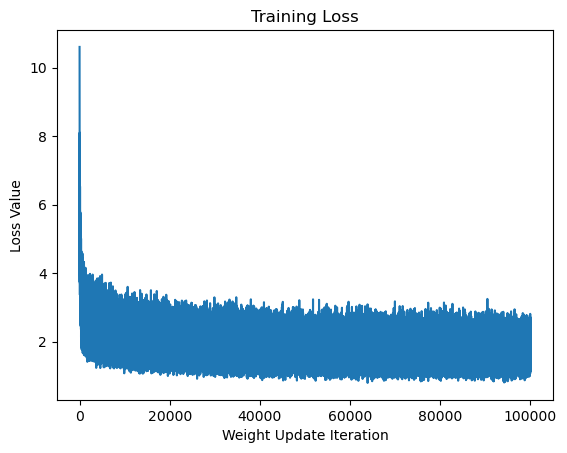

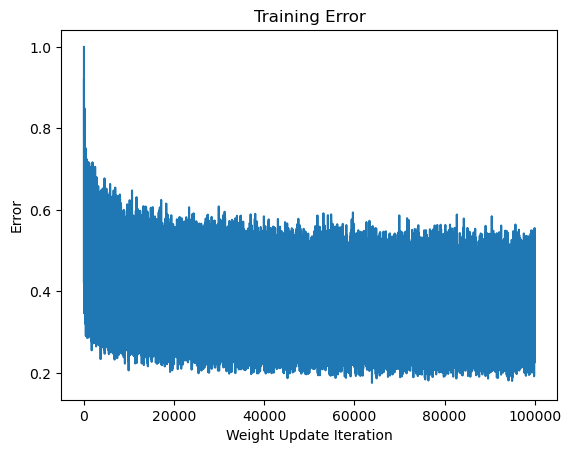

<Figure size 640x480 with 0 Axes>

In [20]:
# output,_ = rnn(input[40].to(device))
# output = [unique_chars[i] for i in torch.argmax(output, dim=1).tolist()]
# output = torch.tensor(unique_chars)
# [torch.argmax(output, dim=1)]
# print(batches[40])
# # print((output))
# # print(output)
# print(error)
# print(current_labels)
# print(torch.argmax(output,dim=1))
# test = [1,2,3,4,5]

# training_error_values = [i.cpu().item() for i in training_error_values]
# validation_error_values = [i.cpu().item() for i in validation_error_values]
# validation_loss_values = [i.cpu().item() for i in validation_loss_values]
x_vals = np.arange(x_val)

plt.figure()
plt.plot(x_vals[0:200000],training_loss_values[0:200000])
plt.xlabel('Weight Update Iteration')
plt.ylabel('Loss Value')
plt.title('Training Loss')
plt.figure()
plt.plot(x_vals[0:200000], training_error_values[0:200000])
plt.xlabel('Weight Update Iteration')
plt.ylabel('Error')
plt.title('Training Error')
plt.figure()
# plt.plot(validation_x_vals, validation_loss_values)
# plt.xlabel('Weight Update Iteration')
# plt.ylabel('Loss Value')
# plt.title('Validation Loss')
# plt.figure()
# plt.plot(validation_x_vals, validation_error_values)
# plt.xlabel('Weight Update Iteration')
# plt.ylabel('Error')
# plt.title('Validation Error')
# plt.show()

In [25]:
test_temperature = 0.9
transformer_model.eval()
capital_letters = [chr(i) for i in range(65, 91)]
example_sentences = []
#initialize = ["I went to the store."]
initialize = ['Alice and Jack walked up the street and met a girl in a red dress. The girl said to them, ”Hi, I’m Jane. What are your names?”']
# initialize = ['Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is']
inference_tokens = 100
for i in range(1):
    sentence = initialize[i]
    tokenized_sentence = tokenizer.encode(sentence)
    next_char = torch.tensor(tokenized_sentence).long().unsqueeze(0).to(device)
    for j in range(inference_tokens):
        next_char = transformer_model(next_char)
        # print(next_char.shape)
        # print(next_char.shape)
        next_softmax = softmax_with_temperature(next_char, test_temperature)
        # predicted_char = torch.argmax(next_softmax,dim=1)
        predicted_char = torch.multinomial(next_softmax[0,-1],1)
        # letter = unique_chars[predicted_char[-1]]
        letter = tokenizer.decode([predicted_char.item()])
        sentence += letter
        # next_char = torch.tensor(tokenize(sentence)).long().to(device)
        next_tokenized_sentence = tokenizer.encode(sentence)
        next_char = torch.tensor(next_tokenized_sentence).unsqueeze(0).long().to(device)
    example_sentences.append(sentence)
example_sentences = np.array(example_sentences)
print(example_sentences[0])
# print(example_sentences[1])
# print(example_sentences[2])
# print(example_sentences[3])
# print(example_sentences[4])

Alice and Jack walked up the street and met a girl in a red dress. The girl said to them, ”Hi, I’m Jane. What are your names?”?"

Lucysmiledandmarepliedcharminginledinandaghettiforledwithed.

"AMay!"saidsaidthecats.

"Iwantwhatlikeso,"said."

standing岛atyrepliedandpatight'seyes."

"It'sa,"saidsaidthepointingtheilledtooed.

"Itlookssoup,"saidsaidsaidas,pointingherdiscoverherbelongedwith.

"
